In [1]:
import warnings

# FutureWarning만 무시
warnings.filterwarnings('ignore', category=FutureWarning)

In [2]:
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from datetime import datetime

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# 데이터 불러오기
from functional.preprocessing import get_price, data_adjust

import pandas as pd

df = get_price('AAPL')

df.drop(['Adj Close'], axis = 1, inplace = True)
origin_open = df['Open'].values
dates = pd.to_datetime(df['Date'])




cuda


[*********************100%***********************]  1 of 1 completed


In [ ]:
from functional.preprocessing import data_adjust

df, dates = data_adjust(df)
df

,Close,High,Low,Open,Volume
0,19.754642,19.893929,19.715000,19.845715,234684800
1,19.320715,19.775000,19.301071,19.745001,392467600
2,19.426071,19.528570,19.057142,19.194643,412610800
3,19.287144,19.498571,19.211430,19.440001,317209200
4,19.409286,19.484285,19.238930,19.243214,258529600
...,...,...,...,...,...
2747,239.589996,240.789993,237.160004,237.270004,48137100
2748,242.649994,242.759995,238.899994,239.809998,38861000
2749,243.009995,244.110001,241.250000,242.869995,44383900
2750,243.039993,244.539993,242.130005,243.990005,40033900


In [ ]:
df = df[8337:]
df = df.reset_index(drop=True)

dates = df['Date']
df = df.drop('Date', axis = 1)

# 
seq_length = 60
batch = 100

# 80% train, 20% test
train_size = int(len(df)*0.8)
train_set = df[0:train_size]

test_set = df[train_size-seq_length:].reset_index(drop = True)

# Input scale
scaler_x = MinMaxScaler()
scaler_x.fit(train_set.iloc[:, 1:])

train_set.iloc[:, 1:] = scaler_x.transform(train_set.iloc[:, 1:])
test_set.iloc[:, 1:] = scaler_x.transform(test_set.iloc[:, 1:])

# Output scale
scaler_y = MinMaxScaler()
scaler_y.fit(train_set.iloc[:, [0]])

train_set.iloc[:, 0] = scaler_y.transform(train_set.iloc[:, [0]])
test_set.iloc[:, 0] = scaler_y.transform(test_set.iloc[:, [0]])

In [623]:
from torch.utils.data import TensorDataset # 텐서데이터셋
from torch.utils.data import DataLoader # 데이터로더

# 데이터셋 생성 함수
def build_dataset(time_series, seq_length):
    dataX = []
    dataY = []
    for i in range(0, len(time_series)-seq_length):
        _x = time_series[i:i+seq_length, :]
        _y = time_series[i+seq_length, [0]]
        # print(_x, "-->",_y)
        dataX.append(_x)
        dataY.append(_y)

    return np.array(dataX), np.array(dataY)

trainX, trainY = build_dataset(np.array(train_set), seq_length)
testX, testY = build_dataset(np.array(test_set), seq_length)

# 텐서로 변환
trainX_tensor = torch.FloatTensor(trainX).to(device)
trainY_tensor = torch.FloatTensor(trainY).to(device)

testX_tensor = torch.FloatTensor(testX).to(device)
testY_tensor = torch.FloatTensor(testY).to(device)

# 텐서 형태로 데이터 정의
dataset = TensorDataset(trainX_tensor, trainY_tensor)

# 데이터로더는 기본적으로 2개의 인자를 입력받으며 배치크기는 통상적으로 2의 배수를 사용
dataloader = DataLoader(dataset,
                        batch_size=batch,
                        shuffle=True,  
                        drop_last=True)

In [624]:
# 설정값
data_dim = 5
hidden_dim = 10 
output_dim = 1 
learning_rate = 0.01
nb_epochs = 500

class LSTM_M(nn.Module):
    def __init__(self, input_dim, hidden_dim, seq_len, output_dim, layers):
        super(LSTM_M, self).__init__()
        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        self.output_dim = output_dim
        self.layers = layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=layers,
                            # dropout = 0.1,
                            batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, 128, bias = True)
        self.fc2 = nn.Linear(128, output_dim, bias = True)
        self.active = nn.Tanh()
        
    def reset_hidden_state(self): 
        self.hidden = (
                torch.zeros(self.layers, self.seq_len, self.hidden_dim),
                torch.zeros(self.layers, self.seq_len, self.hidden_dim))
    
    def forward(self, x):
        x, _status = self.lstm(x)  # (batch_size, seq_len, hidden_dim)
        x = self.fc1(x[:, -1])     # (batch_size, hidden_dim) : last hidden state
        x = self.active(x)
        x = self.fc2(x)            # (batch_size, output_dim)
        return x
    

def train_model(model, train_df, num_epochs = None, lr = None, verbose = 50, patience = 10):

    criterion = nn.MSELoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr = learning_rate)
    nb_epochs = num_epochs
    
    # epoch마다 loss 저장
    train_hist = np.zeros(nb_epochs)

    for epoch in range(nb_epochs):
        avg_cost = 0
        total_batch = len(train_df)
        
        for batch_idx, samples in enumerate(train_df):
            x_train, y_train = samples
            model.reset_hidden_state()
            
            outputs = model(x_train)
            loss = criterion(outputs, y_train)                    
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            avg_cost += loss/total_batch

        train_hist[epoch] = avg_cost        
        
        if epoch % verbose == 0:
            print('Epoch:', '%04d' % (epoch), 'train loss :', '{:.4f}'.format(avg_cost))
            
        if (epoch % patience == 0) & (epoch >= 100):
            
            if (train_hist[epoch-patience] < train_hist[epoch]):
                print(f' Early Stopping : Epoch {epoch} by patience loss.\n Last train loss : {avg_cost}')
                break

    return model.eval(), train_hist

In [625]:
while True:
    MAE_score = []
    train_hists = []
    for num in range(20):

        # 모델 학습
        model = LSTM_M(data_dim, hidden_dim, seq_length, output_dim, 1).to(device)  
        trained_model, train_hist = train_model(model, dataloader, num_epochs = nb_epochs, lr = learning_rate, 
                                        verbose = 20, patience = 10)
        train_hists.append(train_hist)

        # 모델 저장    
        PATH = "./params/model_params_{}/LSTM_{}_days_prediction{}.pth".format(seq_length, seq_length, num)
        torch.save(model.state_dict(), PATH)
        
        # 불러오기
        model = LSTM_M(data_dim, hidden_dim, seq_length, output_dim, 1).to(device)  
        model.load_state_dict(torch.load(PATH), strict=False)
        model.eval()
        
        # 예측 테스트
        with torch.no_grad(): 
            pred = []
            for pr in range(len(testX_tensor)):

                model.reset_hidden_state()

                predicted = model(torch.unsqueeze(testX_tensor[pr], 0))
                predicted = torch.flatten(predicted).item()
                pred.append(predicted)

            # INVERSE
            pred_inverse = scaler_y.inverse_transform(np.array(pred).reshape(-1, 1))
            validY_inverse = scaler_y.inverse_transform(testY_tensor.cpu())

        # plt.plot(np.arange(len(pred_inverse)), pred_inverse, label = 'pred')
        # plt.plot(np.arange(len(validY_inverse)), validY_inverse, label = 'true')
        # days = [str(dates[train_size + i])[:10] for i in [0, 120, 240, 360, 480]]
        # plt.xticks([0, 120, 240, 360, 480], labels = days)
        # plt.title("Prediction Plot")
        # plt.show()

        def MAE(true, pred):
            return np.mean(np.abs(true-pred))

        print('VAL MAE SCORE : ', MAE(pred_inverse, validY_inverse),'\n\n')
        MAE_score.append(MAE(pred_inverse, validY_inverse))

    if min(MAE_score) < 10:
        break

Epoch: 0000 train loss : 0.0303
Epoch: 0020 train loss : 0.0002
Epoch: 0040 train loss : 0.0001
Epoch: 0060 train loss : 0.0001
Epoch: 0080 train loss : 0.0001
Epoch: 0100 train loss : 0.0001
 Early Stopping : Epoch 110 by patience loss.
 Last train loss : 0.00020509528985712677
VAL MAE SCORE :  3.1630559137914043 


Epoch: 0000 train loss : 0.0296
Epoch: 0020 train loss : 0.0001
Epoch: 0040 train loss : 0.0002
Epoch: 0060 train loss : 0.0002
Epoch: 0080 train loss : 0.0001
Epoch: 0100 train loss : 0.0001
Epoch: 0120 train loss : 0.0001
 Early Stopping : Epoch 120 by patience loss.
 Last train loss : 0.0001270742213819176
VAL MAE SCORE :  5.477198657507735 


Epoch: 0000 train loss : 0.0340
Epoch: 0020 train loss : 0.0002
Epoch: 0040 train loss : 0.0001
Epoch: 0060 train loss : 0.0001
Epoch: 0080 train loss : 0.0002
Epoch: 0100 train loss : 0.0002
 Early Stopping : Epoch 100 by patience loss.
 Last train loss : 0.00022217461082618684
VAL MAE SCORE :  6.173813793685738 


Epoch: 0000 tr

MAE SCORE :  2.9565739455845668


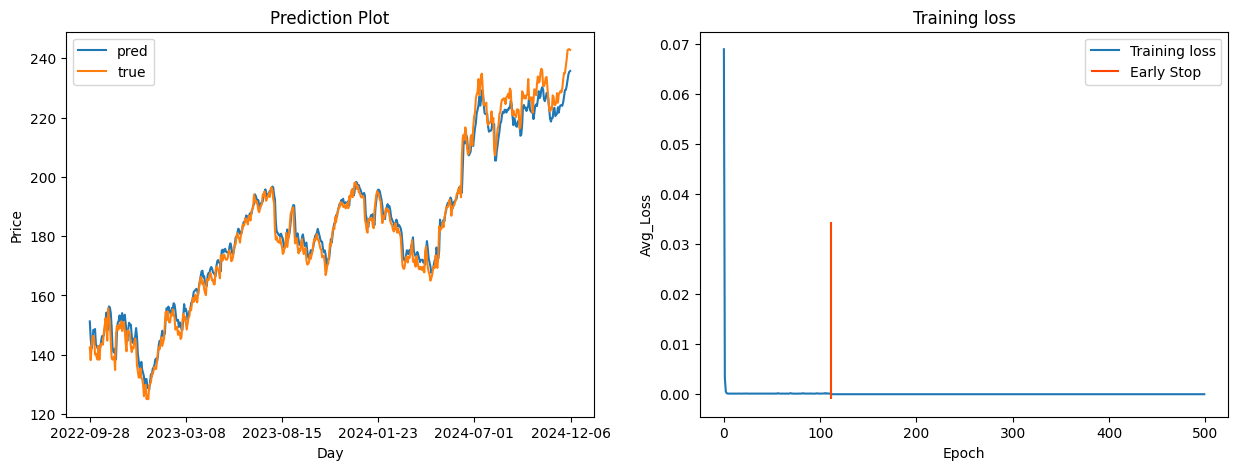

In [626]:
best_params = "./params/model_params_{}/LSTM_{}_days_prediction{}.pth".format(seq_length, seq_length, np.argmin(MAE_score))
model = LSTM_M(data_dim, hidden_dim, seq_length, output_dim, 1).to(device)
model.load_state_dict(torch.load(best_params))
model.eval()

with torch.no_grad(): 
    pred = []
    for pr in range(len(testX_tensor)):

        model.reset_hidden_state()

        predicted = model(torch.unsqueeze(testX_tensor[pr], 0))
        predicted = torch.flatten(predicted).item()
        pred.append(predicted)

    # INVERSE
    pred_inverse = scaler_y.inverse_transform(np.array(pred).reshape(-1, 1))
    testY_inverse = scaler_y.inverse_transform(testY_tensor.cpu())

print('MAE SCORE : ', MAE(pred_inverse, testY_inverse))

days = [str(dates[train_size + i - 1])[:10] for i in list(np.linspace(0, len(testY_tensor), 6, dtype = int))]

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15,5))
ax1.plot(np.arange(len(pred_inverse)), pred_inverse, label = 'pred')
ax1.plot(np.arange(len(testY_inverse)), testY_inverse, label = 'true')
ax1.set_xticks(list(np.linspace(0, len(testY_tensor), 6, dtype = int)), labels = days)
ax1.set(xlabel = 'Day', ylabel = 'Price')
ax1.set_title("Prediction Plot")
ax1.legend()

train_hist_selected = train_hists[np.argmin(MAE_score)]

# Loss per Epoch
ax2.plot(train_hist_selected, label="Training loss")
ax2.vlines(np.argmin(train_hist_selected), ymin = -0.001, ymax= max(train_hist_selected) / 2, colors = 'OrangeRed', label = 'Early Stop')
ax2.set(xlabel = 'Epoch', ylabel = 'Avg_Loss')
ax2.set_title('Training loss')
ax2.legend()

# save model params    
PATH = "./params/best_params/LSTM_{}_days_prediction.pth".format(seq_length)
torch.save(model.state_dict(), PATH)

# save fig
plt.savefig('./fig/seq_len_{}.png'.format(seq_length), facecolor='#eeeeee')


In [656]:
# 실 예측

seq_length = 30

PATH = "./params/best_params/LSTM_{}_days_prediction.pth".format(seq_length)
model = LSTM_M(data_dim, hidden_dim, seq_length, output_dim, 1).to(device)
model.load_state_dict(torch.load(best_params))
model.eval()

LSTM_M(
  (lstm): LSTM(5, 10, batch_first=True)
  (fc1): Linear(in_features=10, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
  (active): Tanh()
)

In [661]:
params = model.state_dict()
dummy_data = torch.empty(0, seq_length, 5, dtype = torch.float32, device=device)


torch.onnx.export(model, dummy_data, 'output.onnx')

c:\project\TSA\.venv\Lib\site-packages\torch\onnx\symbolic_opset9.py:4279: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with LSTM can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  warnings.warn(


In [595]:
a = df.iloc[:-1,:]
b = df.iloc[[-1],:]

a.iloc[:, 1:] = scaler_x.transform(a.iloc[:,1:])
a.iloc[:, 0] = scaler_y.transform(a.iloc[:,[0]])

In [ ]:
asdf = torch.unsqueeze(torch.FloatTensor(a.iloc[-seq_length:, :].values), 0)

tensor([[[ 2.6422e+00,  2.5951e+00,  2.6642e+00,  2.6052e+00, -1.4056e-02],
         [ 2.6527e+00,  2.6243e+00,  2.6789e+00,  2.6023e+00, -6.5149e-03],
         [ 2.6774e+00,  2.6427e+00,  2.7166e+00,  2.6462e+00, -9.1767e-03],
         [ 2.6807e+00,  2.6379e+00,  2.7137e+00,  2.6435e+00, -9.8334e-03],
         [ 2.6364e+00,  2.6274e+00,  2.6786e+00,  2.6375e+00,  1.5910e-03],
         [ 2.5843e+00,  2.5830e+00,  2.6258e+00,  2.5974e+00,  1.8550e-02],
         [ 2.5471e+00,  2.5284e+00,  2.5614e+00,  2.4947e+00,  1.9438e-02],
         [ 2.5359e+00,  2.4972e+00,  2.5543e+00,  2.4949e+00, -4.9359e-04],
         [ 2.5538e+00,  2.5113e+00,  2.5723e+00,  2.5049e+00, -1.6996e-02],
         [ 2.5447e+00,  2.5372e+00,  2.5730e+00,  2.5148e+00,  8.9338e-03],
         [ 2.6038e+00,  2.5592e+00,  2.6157e+00,  2.5396e+00, -3.2452e-03],
         [ 2.5974e+00,  2.5687e+00,  2.6390e+00,  2.5708e+00, -6.9791e-03],
         [ 2.5635e+00,  2.5327e+00,  2.5769e+00,  2.5441e+00, -3.3747e-03],
         [ 2

In [605]:
with torch.no_grad():
    pred = []
    model.reset_hidden_state()

    predicted = model(asdf)
    predicted = torch.flatten(predicted).item()
    pred.append(predicted)
    
    # INVERSE
    pred_inverse = scaler_y.inverse_transform(np.array(pred).reshape(-1, 1))

    print(pred_inverse)

[[8.19650009]]
